In [1]:
!git clone https://github.com/youcef-ely/credit_card_transactions_fraud_detection.git

fatal: destination path 'credit_card_transactions_fraud_detection' already exists and is not an empty directory.


In [2]:
import os

os.chdir("credit_card_transactions_fraud_detection")

In [3]:
!pip install -r requirements.txt --quiet

# Data reading and setting

In [4]:
import src.visualization as vis
import warnings

warnings.resetwarnings()
warnings.simplefilter('ignore')

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("credit_card_fraud_analysis") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/17 18:48:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
data = spark.read.csv("/kaggle/input/processed-data/processed_data", header=True, inferSchema=True)
data.show()

+--------------------+-------------+------+------+----------------+-----+-------+---------+--------+--------------------+------------------+------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|            merchant|     category|   amt|gender|            city|state|    lat|     long|city_pop|                 job|         merch_lat|        merch_long|is_fraud|portion|age|trans_month|trans_hour|trans_day_of_week|trans_day_of_month|trans_day_of_year|distance_km|
+--------------------+-------------+------+------+----------------+-----+-------+---------+--------+--------------------+------------------+------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|fraud_Raynor, Rei...|gas_transport| 61.15|     M|   West Hartford|   VT|43.7185| -72.4439|     140|Development worke...|         44.208355|        -72.133812|       0|  train| 35|       

In [7]:
data.printSchema()

root
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- portion: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- trans_month: integer (nullable = true)
 |-- trans_hour: integer (nullable = true)
 |-- trans_day_of_week: integer (nullable = true)
 |-- trans_day_of_month: integer (nullable = true)
 |-- trans_day_of_year: integer (nullable = true)
 |-- distance_km: double (nullable = true)



In [8]:
min_sample = data.groupby('is_fraud').count().orderBy('count').limit(1).collect()[0][1]
min_sample

9651

# Numerical columns

In [9]:
from pyspark.sql.types import NumericType

numerical_columns = [col for col, dtype in data.dtypes if isinstance(data.schema[col].dataType, NumericType) and col != 'is_fraud']
numerical_columns

['amt',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'trans_month',
 'trans_hour',
 'trans_day_of_week',
 'trans_day_of_month',
 'trans_day_of_year',
 'distance_km']

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vectorAssembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
data_vector = vectorAssembler.transform(data)

correlation_matrix = Correlation.corr(data_vector, "features").head()[0]

24/12/17 18:48:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<Axes: >

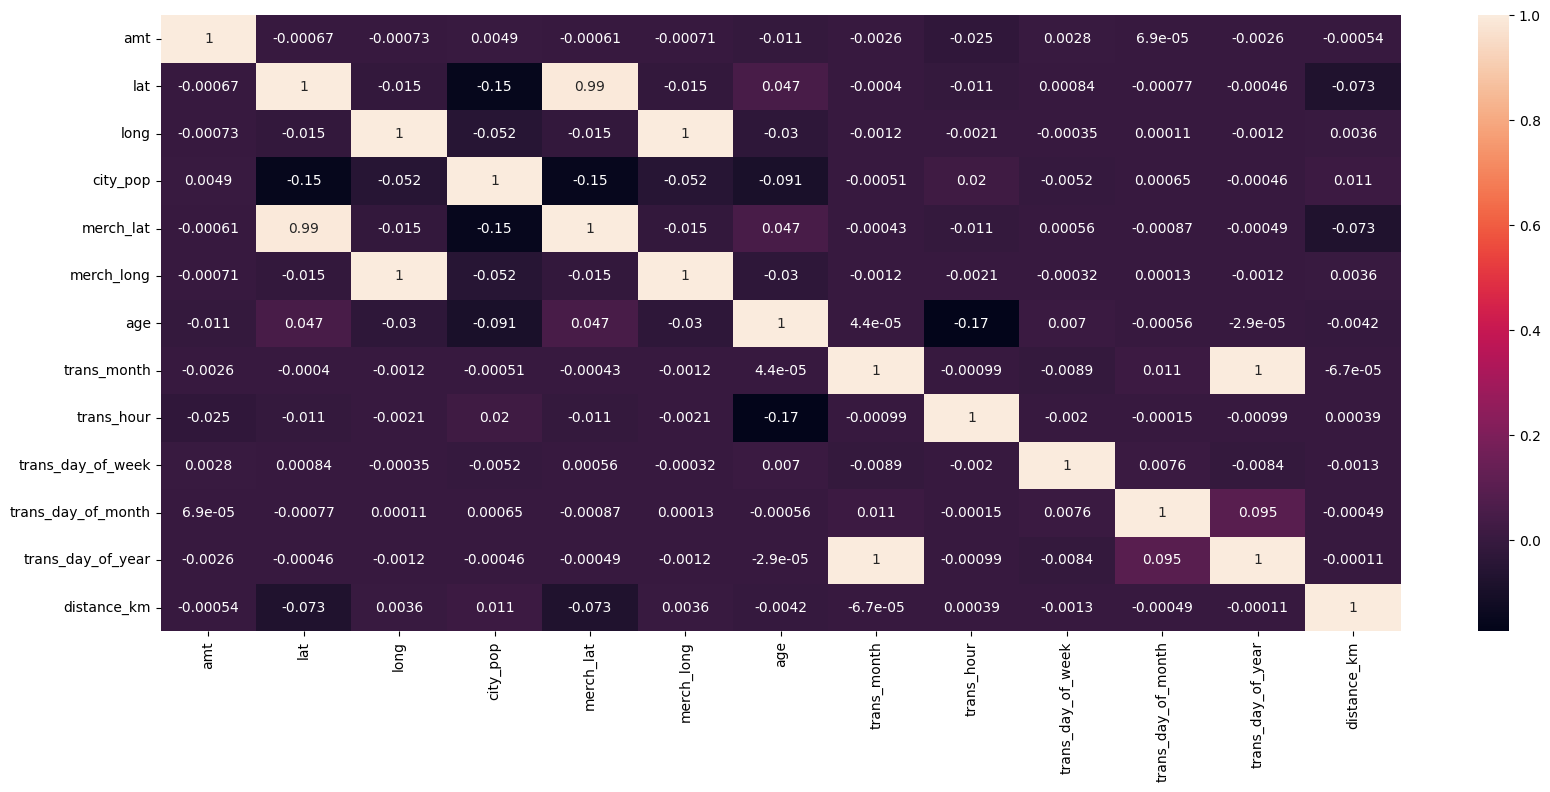

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix.toArray(), annot=True, xticklabels=numerical_columns, yticklabels=numerical_columns)

## Coordinates features

In [12]:
coordinates = data.select('merch_lat', 'lat', 'long', 'merch_long', 'is_fraud').toPandas()
coordinates

merch_lat      lat      long  merch_long  is_fraud
0        44.208355  43.7185  -72.4439  -72.133812         0
1        27.064663  26.5290  -82.0916  -81.798000         0
2        32.063623  31.1569  -94.3871  -95.240577         0
3        33.941192  33.6773 -118.0051 -118.127544         0
4        42.216841  43.0330  -77.1575  -76.889115         0
...            ...      ...       ...         ...       ...
1852389  33.180884  33.5623 -112.0559 -111.231888         0
1852390  38.732033  39.1505  -79.5030  -80.028952         0
1852391  36.801052  36.3850  -98.0727  -97.874738         0
1852392  29.800436  29.4790  -95.9681  -96.035814         0
1852393  41.454121  40.5553  -77.4001  -77.365334         0

[1852394 rows x 5 columns]

In [13]:
coordinates_sample = coordinates.groupby('is_fraud').apply(lambda x: x.sample(min_sample)).reset_index(drop=True)
coordinates_sample

merch_lat      lat      long  merch_long  is_fraud
0      33.366271  34.1556 -118.2322 -117.516357         0
1      43.279799  44.0943  -69.4828  -69.735918         0
2      33.487849  32.9643  -96.6012  -96.955383         0
3      38.251530  37.7878 -122.1884 -121.836104         0
4      38.798464  39.1412  -94.3515  -94.144969         0
...          ...      ...       ...         ...       ...
19297  40.661386  40.8170  -74.0000  -73.816473         1
19298  42.005098  41.3851  -80.1752  -80.485252         1
19299  40.376900  40.1151  -79.8627  -78.865720         1
19300  41.569284  41.0233  -98.9041  -98.876450         1
19301  42.580576  42.6911  -71.1605  -70.233212         1

[19302 rows x 5 columns]

In [14]:
coordinates_sample['is_fraud'].value_counts()

is_fraud
0    9651
1    9651
Name: count, dtype: int64

In [15]:
import pygwalker as pyg
gwalker = pyg.walk(coordinates_sample)

Box(children=(HTML(value='\n<div id="ifr-pyg-0006297bc1673d5cw9vyJSWijoHu71lA" style="height: auto">\n    <hea…

In [16]:
gwalker = pyg.walk(coordinates)

Box(children=(HTML(value='\n<div id="ifr-pyg-0006297bc1742038bkAc3Z5GIPvCzif6" style="height: auto">\n    <hea…

`There is a high correlation between merch_lat and lat, but no significant pattern in the coordinates data.`

In [17]:
del coordinates_sample, gwalker, coordinates

In [18]:
data = data.drop('merch_lat', 'lat', 'long', 'merch_long')
data.show()

+--------------------+-------------+------+------+----------------+-----+--------+--------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|            merchant|     category|   amt|gender|            city|state|city_pop|                 job|is_fraud|portion|age|trans_month|trans_hour|trans_day_of_week|trans_day_of_month|trans_day_of_year|distance_km|
+--------------------+-------------+------+------+----------------+-----+--------+--------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|fraud_Raynor, Rei...|gas_transport| 61.15|     M|   West Hartford|   VT|     140|Development worke...|       0|  train| 35|          8|        10|                1|                 4|              216|   59.85688|
|fraud_Vandervort-...|  grocery_pos| 55.25|     M|Saint James City|   FL|    3776|Sport and exercis...|       0|  train| 48|          8|    

In [19]:
removed_cols = ['merch_lat', 'lat', 'long', 'merch_long']
numerical_columns = [col for col in numerical_columns if col not in removed_cols]

In [20]:
num_data = data.select(numerical_columns + ['is_fraud']).toPandas().groupby('is_fraud').apply(lambda x: x.sample(min_sample)).reset_index(drop=True)
num_data

amt  city_pop  age  trans_month  trans_hour  trans_day_of_week  \
0       193.74      6120   48            6           5                  4   
1        86.41      3032   60           12          20                  6   
2        77.77      2872   37            7           4                  5   
3        18.15     45100   31            3          19                  6   
4        86.33     71485   50            6          15                  2   
...        ...       ...  ...          ...         ...                ...   
19297     9.77       759   68            3          22                  2   
19298   758.13      1892   68            1          23                  4   
19299  1096.03     16955   63            2          23                  5   
19300  1010.04      3994   88            3          22                  3   
19301  1077.64      1100   74            6          22                  5   

       trans_day_of_month  trans_day_of_year  distance_km  is_fraud  
0                       3                155    94.091880         0  
1                      11                346    81.403150         0  
2                       9                191    45.587826         0  
3                       8                 67    78.902570         0  
4                       3                154    31.629670         0  
...                   ...                ...          ...       ...  
19297                  16                 76    50.411310         1  
19298                  16                 16    47.985054         1  
19299                   7                 38   118.439540         1  
19300                  31                 91   118.957800         1  
19301                  18                170    39.455475         1  

[19302 rows x 10 columns]

Plotting KDE plots grouped by is_fraud: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


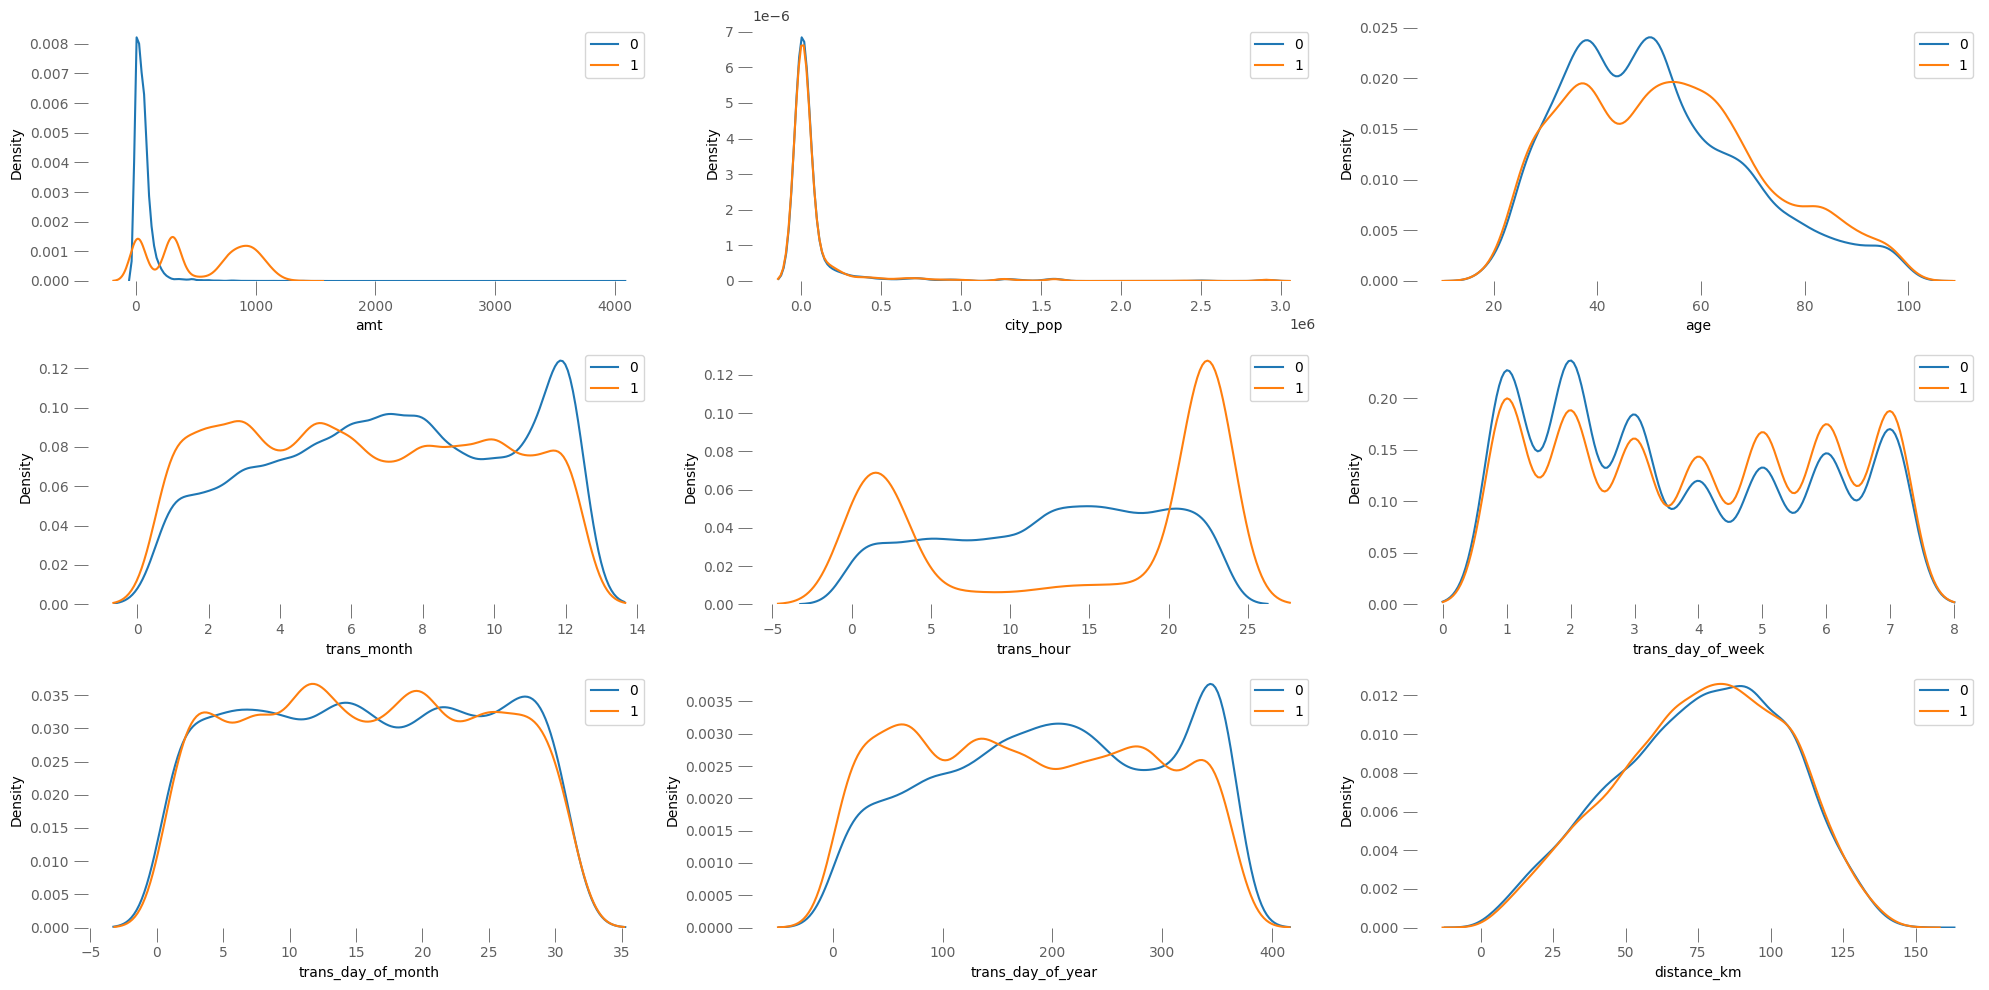

In [21]:
vis.kdeplots(num_data, shape = (3, 3), y='is_fraud')

In [22]:
#Generating new features
import numpy as np

for col in numerical_columns:
  num_data[f'ln_{col}'] = np.log(num_data[col] + 1e-6)
  num_data[f'sqrt_{col}'] = np.sqrt(num_data[col])
num_data.head()

amt  city_pop  age  trans_month  trans_hour  trans_day_of_week  \
0  193.74      6120   48            6           5                  4   
1   86.41      3032   60           12          20                  6   
2   77.77      2872   37            7           4                  5   
3   18.15     45100   31            3          19                  6   
4   86.33     71485   50            6          15                  2   

   trans_day_of_month  trans_day_of_year  distance_km  is_fraud  ...  \
0                   3                155    94.091880         0  ...   
1                  11                346    81.403150         0  ...   
2                   9                191    45.587826         0  ...   
3                   8                 67    78.902570         0  ...   
4                   3                154    31.629670         0  ...   

   ln_trans_hour  sqrt_trans_hour  ln_trans_day_of_week  \
0       1.609438         2.236068              1.386295   
1       2.995732         4.472136              1.791760   
2       1.386295         2.000000              1.609438   
3       2.944439         4.358899              1.791760   
4       2.708050         3.872983              0.693148   

   sqrt_trans_day_of_week  ln_trans_day_of_month  sqrt_trans_day_of_month  \
0                2.000000               1.098613                 1.732051   
1                2.449490               2.397895                 3.316625   
2                2.236068               2.197225                 3.000000   
3                2.449490               2.079442                 2.828427   
4                1.414214               1.098613                 1.732051   

   ln_trans_day_of_year  sqrt_trans_day_of_year  ln_distance_km  \
0              5.043425               12.449900        4.544272   
1              5.846439               18.601075        4.399414   
2              5.252273               13.820275        3.819641   
3              4.204693                8.185353        4.368214   
4              5.036953               12.409674        3.454096   

   sqrt_distance_km  
0          9.700097  
1          9.022369  
2          6.751876  
3          8.882712  
4          5.624026  

[5 rows x 28 columns]

Plotting KDE plots grouped by is_fraud: 100%|██████████| 18/18 [00:03<00:00,  5.77it/s]


<Figure size 640x480 with 0 Axes>

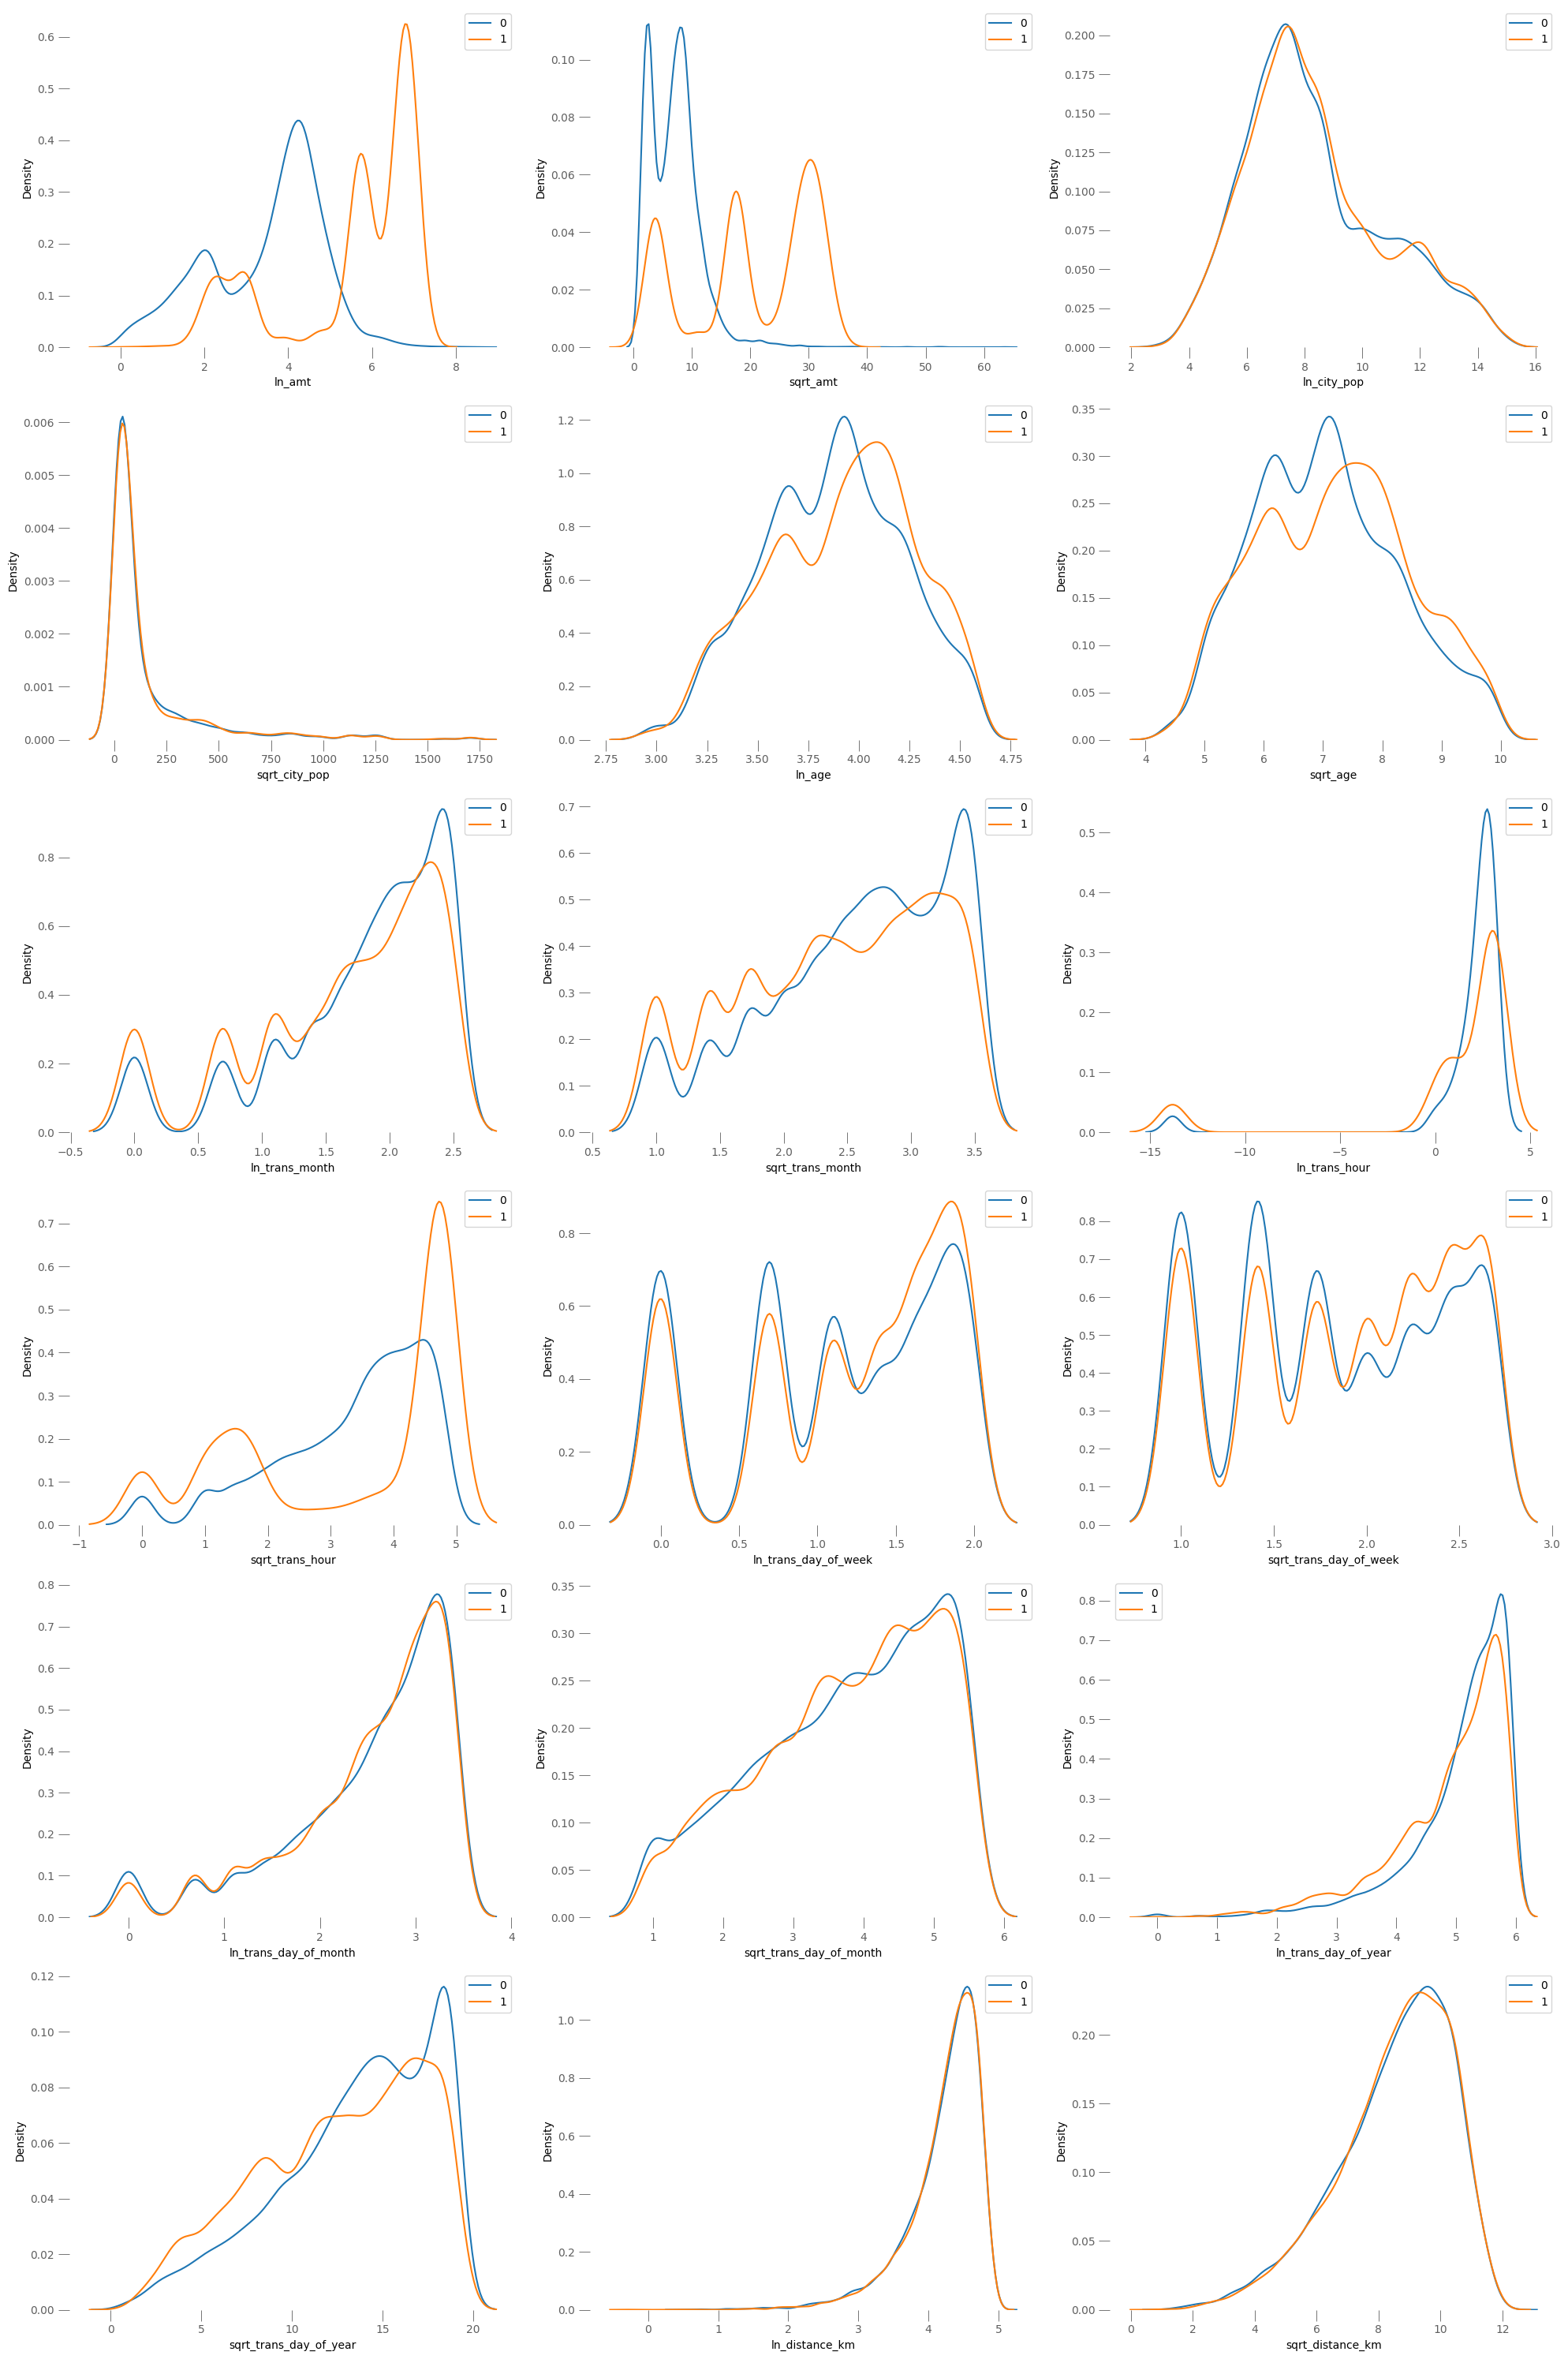

In [23]:
columns_to_plot = [
    col for col in num_data.columns
    if ('ln' in col or 'sqrt' in col) or col == 'is_fraud'
]
vis.kdeplots(num_data[columns_to_plot], y='is_fraud', shape = (6, 3), figsize=(20, 30))

# Categorial Columns

In [24]:
categorical_columns = [col for col, dtype in data.dtypes if dtype == 'string' and col != 'portion']
categorical_columns

['merchant', 'category', 'gender', 'city', 'state', 'job']

In [25]:
BOLD = "\033[1m"
RESET = "\033[0m"

for col in categorical_columns:
    print(f'{BOLD}{col}{RESET}: ')

    distinct_count = data.select(col).distinct().count()
    print(f'\tNumber of distinct values in {col}: {distinct_count}')

    top_10_categories = data.groupBy(col).count() \
                            .orderBy("count", ascending=False) \
                            .limit(10)

    print(f'\tTop 10 most frequent categories in {col}:')
    for row in top_10_categories.collect():
        print(f'\t\t{row[col]}: {row["count"]}')


    mode_row = top_10_categories.first()
    if mode_row:
        mode_value = mode_row[col]
        mode_count = mode_row["count"]
        print(f'\tMode of {col}: {mode_value} with count {mode_count}')
    print()


merchant: 


	Number of distinct values in merchant: 693
	Top 10 most frequent categories in merchant:


		fraud_Kilback LLC: 6262
		fraud_Cormier LLC: 5246
		fraud_Schumm PLC: 5195
		fraud_Kuhn LLC: 5031
		fraud_Boyer PLC: 4999
		fraud_Dickinson Ltd: 4953
		fraud_Emard Inc: 3867
		fraud_Cummerata-Jones: 3860
		fraud_Corwin-Collins: 3853
		fraud_Rodriguez Group: 3843


	Mode of merchant: fraud_Kilback LLC with count 6262

category: 


	Number of distinct values in category: 14
	Top 10 most frequent categories in category:


		gas_transport: 188029
		grocery_pos: 176191
		home: 175460
		shopping_pos: 166463
		kids_pets: 161727
		shopping_net: 139322
		entertainment: 134118
		food_dining: 130729
		personal_care: 130085
		health_fitness: 122553


	Mode of category: gas_transport with count 188029

gender: 


	Number of distinct values in gender: 2
	Top 10 most frequent categories in gender:


		F: 1014749
		M: 837645


	Mode of gender: F with count 1014749

city: 


	Number of distinct values in city: 906
	Top 10 most frequent categories in city:


		Birmingham: 8040
		San Antonio: 7312
		Utica: 7309
		Phoenix: 7297
		Meridian: 7289
		Warren: 6584
		Conway: 6574
		Cleveland: 6572
		Thomas: 6571
		Houston: 5865


	Mode of city: Birmingham with count 8040

state: 


	Number of distinct values in state: 51
	Top 10 most frequent categories in state:


		TX: 135269
		NY: 119419
		PA: 114173
		CA: 80495
		OH: 66627
		MI: 65825
		IL: 62212
		FL: 60775
		AL: 58521
		MO: 54904


	Mode of state: TX with count 135269

job: 


	Number of distinct values in job: 497


	Top 10 most frequent categories in job:


		Film/video editor: 13898
		Exhibition designer: 13167
		Surveyor, land/geomatics: 12436
		Naval architect: 12434
		Materials engineer: 11711
		Designer, ceramics/pottery: 11688
		Environmental consultant: 10974
		Financial adviser: 10963
		Systems developer: 10962
		IT trainer: 10943


	Mode of job: Film/video editor with count 13898



In [28]:
cat_data = data.select(categorical_columns + ['is_fraud'])
cat_data.show()

+--------------------+-------------+------+----------------+-----+--------------------+--------+
|            merchant|     category|gender|            city|state|                 job|is_fraud|
+--------------------+-------------+------+----------------+-----+--------------------+--------+
|fraud_Raynor, Rei...|gas_transport|     M|   West Hartford|   VT|Development worke...|       0|
|fraud_Vandervort-...|  grocery_pos|     M|Saint James City|   FL|Sport and exercis...|       0|
| fraud_Stracke-Lemke|  grocery_pos|     M|         Zavalla|   TX| Designer, jewellery|       0|
|fraud_Schamberger...|  grocery_pos|     F|Huntington Beach|   CA|Therapist, hortic...|       0|
|fraud_Schamberger...|  grocery_pos|     F|     Port Gibson|   NY|Database administ...|       0|
|fraud_Schamberger...|  grocery_pos|     F|    Santa Monica|   CA|Civil engineer, c...|       0|
|   fraud_Kilback LLC|  grocery_pos|     M|         Comfrey|   MN|Health and safety...|       0|
|fraud_Heller-Langosh|gas_tran

In [29]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import col


cat_data = StringIndexer(inputCols=categorical_columns, outputCols=[f"indexed_{col}" for col in categorical_columns]).fit(cat_data).transform(cat_data)
cat_data.show()

+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+
|            merchant|     category|gender|            city|state|                 job|is_fraud|indexed_merchant|indexed_category|indexed_gender|indexed_city|indexed_state|indexed_job|
+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+
|fraud_Raynor, Rei...|gas_transport|     M|   West Hartford|   VT|Development worke...|       0|            32.0|             0.0|           1.0|       217.0|         38.0|       98.0|
|fraud_Vandervort-...|  grocery_pos|     M|Saint James City|   FL|Sport and exercis...|       0|           106.0|             1.0|           1.0|       296.0|          7.0|      241.0|
| fraud_Stracke-Lemke|  grocery_pos|     M|         Zavalla|   TX| Designer

In [30]:
assembled_features = VectorAssembler(inputCols=[f"indexed_{col}" for col in categorical_columns], outputCol="features")
cat_data = assembled_features.transform(cat_data)
cat_data.show()

+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+--------------------+
|            merchant|     category|gender|            city|state|                 job|is_fraud|indexed_merchant|indexed_category|indexed_gender|indexed_city|indexed_state|indexed_job|            features|
+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+--------------------+
|fraud_Raynor, Rei...|gas_transport|     M|   West Hartford|   VT|Development worke...|       0|            32.0|             0.0|           1.0|       217.0|         38.0|       98.0|[32.0,0.0,1.0,217...|
|fraud_Vandervort-...|  grocery_pos|     M|Saint James City|   FL|Sport and exercis...|       0|           106.0|             1.0|           1.0|       296.0|          7.0|    

In [31]:
chiSqResult = ChiSquareTest.test(cat_data, 'features', 'is_fraud')

In [32]:
chiSqResult.show()

+--------------------+--------------------+--------------------+
|             pValues|    degreesOfFreedom|          statistics|
+--------------------+--------------------+--------------------+
|[0.0,0.0,1.776356...|[692, 13, 1, 905,...|[8761.09387377939...|
+--------------------+--------------------+--------------------+



In [33]:
p_values = chiSqResult.head().pValues
chi2_stats = chiSqResult.head().statistics

features = [f"indexed_{col}" for col in categorical_columns]

for feature, p_value, chi2_stat in zip(features, p_values, chi2_stats):
    print(f"Feature: {feature}, Chi-Square Stat: {chi2_stat}, p-value: {p_value}")

Feature: indexed_merchant, Chi-Square Stat: 8761.093873779399, p-value: 0.0
Feature: indexed_category, Chi-Square Stat: 8329.139945520074, p-value: 0.0
Feature: indexed_gender, Chi-Square Stat: 63.25402213730509, p-value: 1.7763568394002505e-15
Feature: indexed_city, Chi-Square Stat: 139590.93742658128, p-value: 0.0
Feature: indexed_state, Chi-Square Stat: 2022.1228324519125, p-value: 0.0
Feature: indexed_job, Chi-Square Stat: 48073.228171839364, p-value: 0.0
